In [2]:
import trackpy as tp 
import pims
import glob
import numpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import bmc
from tqdm import trange
import astropy.units as u
import astropy.constants as c

In [3]:
x10 = 9.51/13
x20 = 9.51/24
x40 = 9.51/57
fps = 30

In [4]:
def onion_path(onion, flow):
    path = "../data/onion_%s/Onion_%s_20x*"%(onion, flow)
    return glob.glob(path)

folder_paths = glob.glob("../data/onion_4/*")
onion_4 = onion_path("4", "bulk")

def all_velocity(t):
    all_vel = np.array([])
    for i in np.unique(t["particle"]):
        all_vel = np.append(all_vel, np.mean(bmc.particle_velocity(t, i, x20, fps)[0]))
    return all_vel

def all_viscosity(t):
    all_visc = np.array([])
    for i in np.unique(t["particle"]):
        all_visc = np.append(all_visc, np.mean(bmc.viscosity(t, i, x20, fps)))
    return all_visc

def radius(t):
    R_gyration = t["size"].values
    mean_R_gyration = np.mean(R_gyration)
    r = np.sqrt(5/3 * mean_R_gyration**2)
    return r

def all_velocity_threshold(t, threshold):
    all_vel = np.array([])
    x_vel = np.array([])
    y_vel = np.array([])
    for i in np.unique(t["particle"]):
#         mean_dx = np.append(mean_dx, np.mean(np.diff(t["x"])))
#         mean_dy = np.append(mean_dy, np.mean(np.diff(t["y"])))
        df = t[t["particle"]==i]
        dx = np.diff(df["x"])
        dy = np.diff(df["y"])
        disp = np.sum(np.sqrt(dx**2 + dx**2))
        if disp > threshold:
            mag, x, y = bmc.particle_velocity(t, i, x20, fps)
            all_vel = np.append(all_vel, np.mean(mag))
            x_vel = np.append(x_vel, np.mean(x))
            y_vel = np.append(y_vel, np.mean(y))
    return all_vel, x_vel, y_vel

In [5]:
all_velocities = np.array([])
all_viscosities= np.array([])
all_radii = np.array([])
for folder in folder_paths:
    path = folder + "/*.bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=6, clip_stubs=25)
    all_velocities = np.append(all_velocities, all_velocity(t))
    all_viscosities= np.append(all_viscosities, all_viscosity(t))
    all_radii = np.append(all_radii, radius(t))

Frame 443: 5 trajectories present.


20.459274041856432

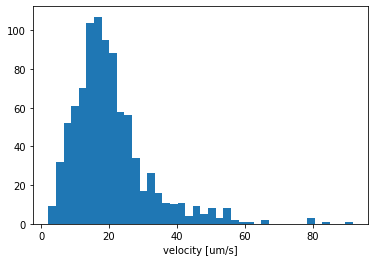

In [6]:
plt.figure()
cnts,_,_ = plt.hist(all_velocities, bins=40, log=0)#, bins=np.linspace(0,13))
plt.xlabel("velocity [um/s]");
velo = np.mean(all_velocities)
velo

6.424444048487947

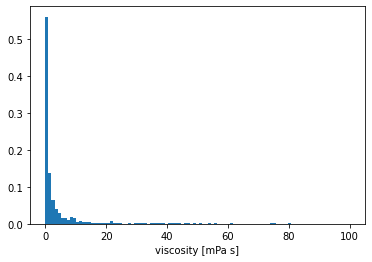

In [7]:
plt.figure()
cnts,_,_ = plt.hist(all_viscosities, bins=np.linspace(0,100, 100), density=1)#, bins=np.linspace(0,13))
plt.xlabel("viscosity [mPa s]");
visc = np.mean(all_viscosities)
visc

2.933235359518904

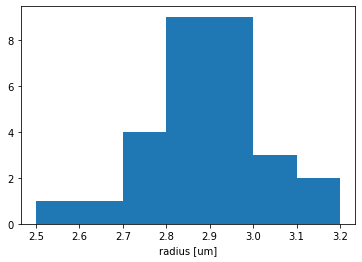

In [8]:
plt.figure()
cnts,_,_ = plt.hist(all_radii, bins=np.linspace(2.5, 3.2, 8))#, bins=np.linspace(0,13))
plt.xlabel("radius [um]");
radii = np.mean(all_radii)
radii

In [38]:
def work(velocity, viscosity, radius, x):
    v = velocity
    n = viscosity
    r = radius
    #x = 200 #units um
    return 3*np.pi*n*r*v*x

x_test = np.linspace(10,400,1000)
total_work = work(velo, visc, radii, 200)
total_work

726731.1995307367

In [10]:
def motors(work):
    free_e = 57.5 * 1000 #* 6.0221409e+23
    return np.ceil(work / free_e)

#motors(total_work)

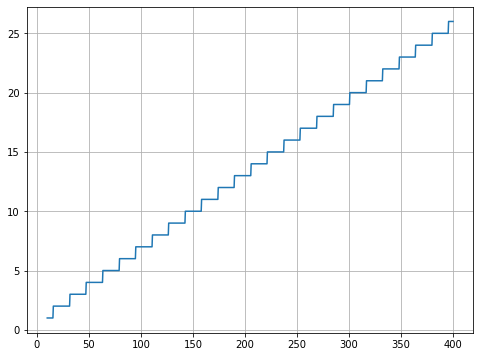

In [11]:
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(x_test, motors(total_work))

# Good Data

In [12]:
good_traj = ["Onion_bulk_20x-13", "Onion_bulk_20x-17", "Onion_bulk_20x-18", "Onion_bulk_20x-19",
             "Onion_bulk_20x-21", "Onion_bulk_20x-24", "Onion_bulk_20x-25", "Onion_bulk_20x-26",
             "Onion_bulk_20x-28"]

brownian = ["Onion_bulk_20x-6", "Onion_bulk_20x-16", "Onion_bulk_20x-27", "Onion_bulk_20x-29"]

both = ["Onion_bulk_20x-13", "Onion_bulk_20x-17", "Onion_bulk_20x-18", "Onion_bulk_20x-19",
             "Onion_bulk_20x-21", "Onion_bulk_20x-24", "Onion_bulk_20x-25", "Onion_bulk_20x-26",
             "Onion_bulk_20x-28", "Onion_bulk_20x-6", "Onion_bulk_20x-16", "Onion_bulk_20x-27", "Onion_bulk_20x-29"]

In [13]:
avg_rad = np.array([])
for folder in both:
    path = "../data/onion_4/" + folder + "/*bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=6, clip_stubs=25)
    avg_rad = np.append(avg_rad, radius(t))

Frame 250: 13 trajectories present.


In [14]:
rad = np.mean(avg_rad)
rad

2.8957357607321907

In [15]:
good_visc = np.array([])
for folder in brownian:
    path = "../data/onion_4/" + folder + "/*bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=6, clip_stubs=25)
    good_visc = np.append(good_visc, all_viscosity(t))

Frame 250: 13 trajectories present.


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

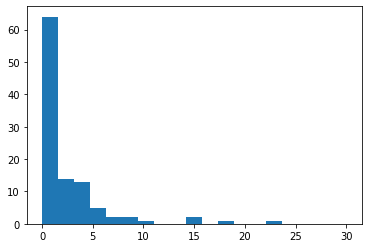

In [44]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return amp*np.exp(-0.5 * (x - mu)**2/sigma**2) 

bins = np.linspace(0, 30, 20)

bin_height, bin_edges, _= plt.hist(good_visc, bins=bins)

step = np.diff(bin_edges)[0]
x_pts = np.arange(bin_edges[0] + 0.5*step, bin_edges[-1]+0.5*step, step)
popt, pcov = curve_fit(gaussian, x_pts, bin_height, p0=(1, 1, 1))


xx = np.linspace(bin_edges[0], bin_edges[-1], 1000)
plt.plot(xx, gaussian(xx, *popt), label="mean = %s um$^2$\n$\sigma$ = %s um$^2$\n"%(np.round(popt[1], 5), np.round(np.abs(popt[2]), 5)), linestyle="--", color="crimson")
plt.legend()

In [34]:
avg_visc = np.mean(good_visc)
avg_visc

2.718379517298967

In [35]:
good_velo = np.array([])
for folder in good_traj:
    path = "../data/onion_4/" + folder + "/*bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=5, clip_stubs=25)
    good_velo = np.append(good_velo, all_velocity_threshold(t, 5)[0])

Frame 249: 13 trajectories present.


In [36]:
avg_velo = np.mean(good_velo)
avg_velo

21.51794007228103

In [168]:
good_work = work(avg_velo, avg_visc, rad, 200)

In [169]:
motors(good_work)

6.0

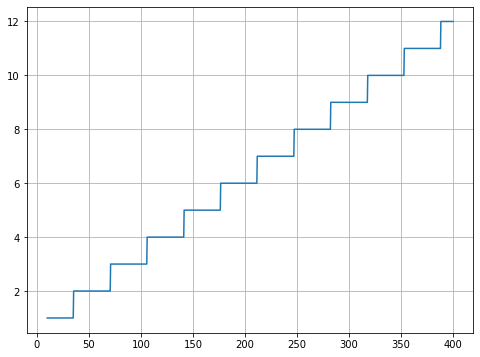

In [162]:
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(x_test, motors(good_work))